In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
import json

import seaborn as sns
color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5 
plt.rcParams['lines.markersize'] = 4
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14

In [82]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df['fecha'] = pd.to_datetime(df['fecha'])

### Entreno y prueba con 2024

In [83]:
FEATURES = json.load(open('features.json', 'r', encoding='utf-8'))
TARGET = 'granos_de_polen_x_metro_cubico'

train_data = df[df['fecha'].dt.year < 2024].dropna(subset=[TARGET])
test_data = df[df['fecha'].dt.year == 2024].dropna(subset=[TARGET])

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
y_train_log = np.log1p(y_train)

X_test = test_data[FEATURES]
y_test = test_data[TARGET]
y_test_log = np.log1p(y_test)

In [84]:
# Añadir pesos

def calculate_weights(target_y, features_X):
    weights = np.ones(len(target_y))
    weights[target_y >= 50] = 100.0
    if 'polen_lag_1' in features_X.columns:
        jump = target_y - features_X['polen_lag_1']
        weights[jump >= 300] = 700.0
    return weights

pesos = calculate_weights(y_train, X_train)


In [85]:
# Eliminar características con baja importancia (creando un modelo previo)

prelim_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=741,
                        max_depth=5,
                        objective='reg:squarederror',
                        learning_rate=0.05016743214009948,
                        subsample=0.5778327912021376,
                        colsample_bytree=0.5242898344250857,
                        gamma=3.9902020819584716)
prelim_reg.fit(X_train, y_train_log)

importancias = pd.DataFrame({
    'feature': FEATURES, 
    'importance': prelim_reg.feature_importances_
}).sort_values('importance', ascending=False)

TOP_FEATURES = importancias[importancias['importance'] > 0.002]['feature'].tolist()

if len(TOP_FEATURES) < 10:
    TOP_FEATURES = importancias.head(10)['feature'].tolist()

X_train_clean = X_train[TOP_FEATURES]
X_test_clean = X_test[TOP_FEATURES]

In [86]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                        n_estimators=741,
                        max_depth=5,
                        objective='reg:squarederror',
                        learning_rate=0.05016743214009948,
                        subsample=0.5778327912021376,
                        colsample_bytree=0.5242898344250857,
                        gamma=3.9902020819584716)

reg.fit(X_train_clean, y_train_log,
        eval_set=[(X_train_clean, y_train_log), (X_test_clean, y_test_log)],
        verbose=100, sample_weight=pesos)

preds_log = reg.predict(test_data[TOP_FEATURES])
preds_reales = np.expm1(preds_log)
test_data['prediccion'] = preds_reales

[0]	validation_0-rmse:1.38025	validation_1-rmse:1.37118


[100]	validation_0-rmse:0.38354	validation_1-rmse:0.47976
[200]	validation_0-rmse:0.37278	validation_1-rmse:0.47152
[300]	validation_0-rmse:0.36932	validation_1-rmse:0.46761
[400]	validation_0-rmse:0.36782	validation_1-rmse:0.46727
[500]	validation_0-rmse:0.36713	validation_1-rmse:0.46632
[600]	validation_0-rmse:0.36647	validation_1-rmse:0.46574
[700]	validation_0-rmse:0.36592	validation_1-rmse:0.46520
[740]	validation_0-rmse:0.36486	validation_1-rmse:0.46451


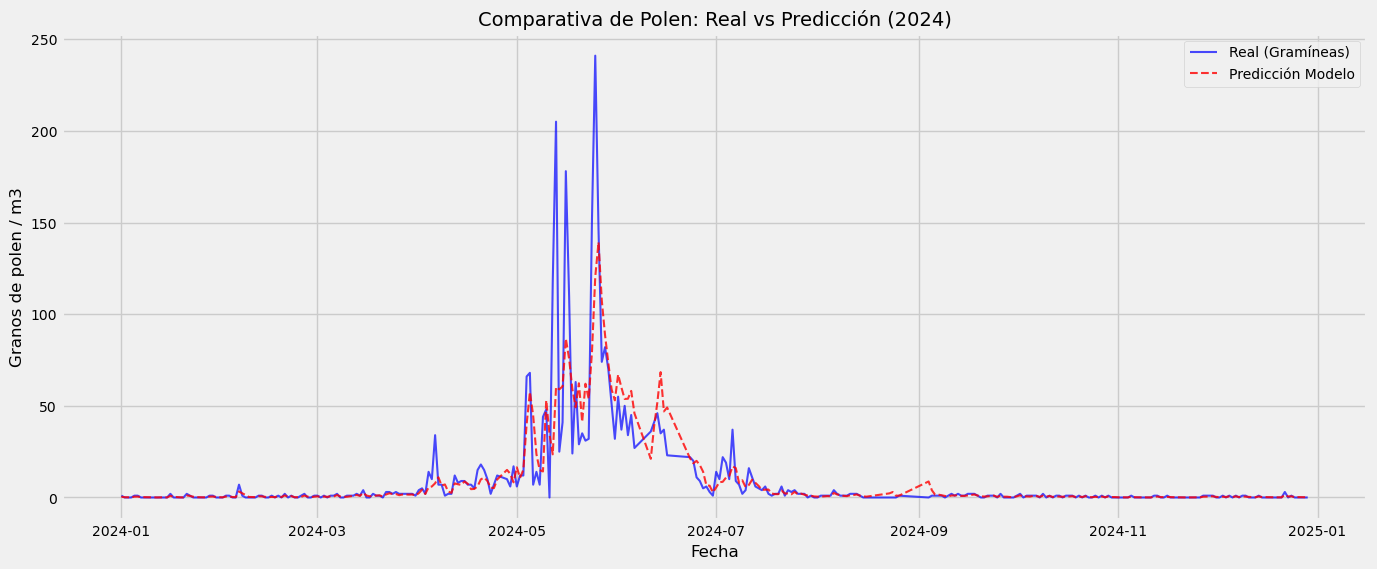

--- Métricas para el año 2024 ---
Error Medio Absoluto (MAE): 4.57 granos
Coeficiente de determinación (R2): 0.68


In [87]:
# Visualizar todo el año

plt.figure(figsize=(15, 6))

plt.plot(test_data['fecha'], test_data[TARGET], label='Real (Gramíneas)', color='blue', alpha=0.7)
plt.plot(test_data['fecha'], test_data['prediccion'], label='Predicción Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparativa de Polen: Real vs Predicción (2024)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / m3')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(test_data[TARGET], test_data['prediccion'])
r2 = r2_score(test_data[TARGET], test_data['prediccion'])

print(f"--- Métricas para el año 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación (R2): {r2:.2f}")

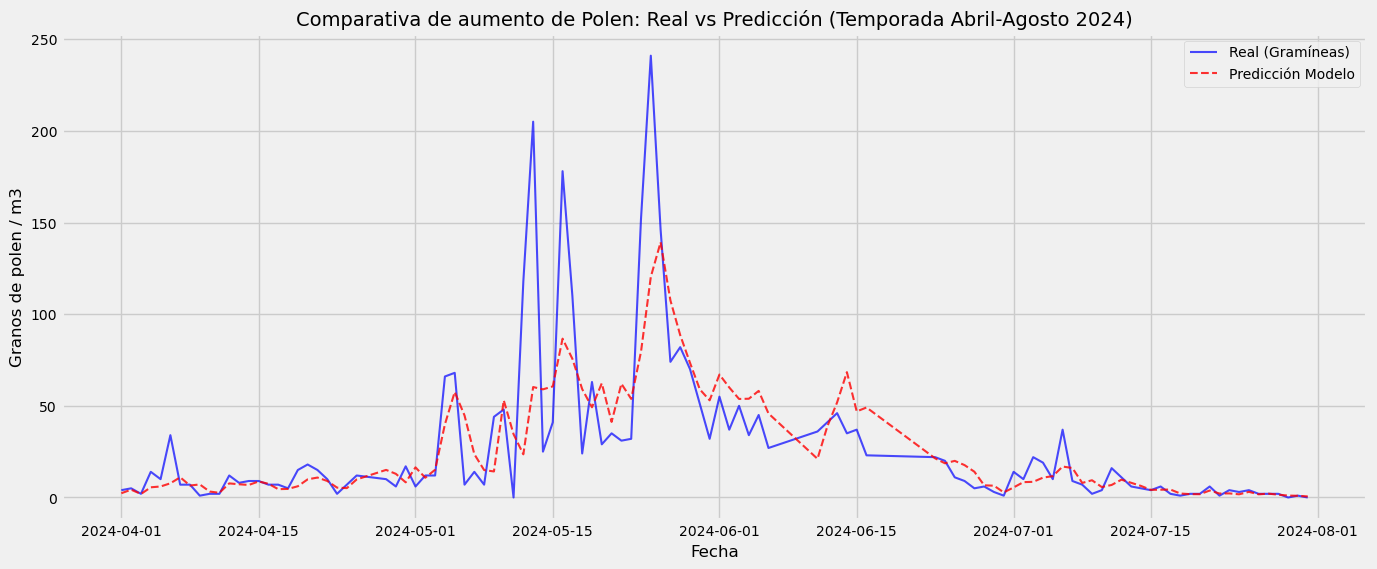

--- Métricas para el periodo Abril-Agosto 2024 ---
Error Medio Absoluto (MAE): 13.10 granos
Coeficiente de determinación (R2): 0.60


In [88]:
# Solo meses importantes

test_data_temporada = test_data[test_data['fecha'].dt.month.between(4, 7)].copy()

plt.figure(figsize=(15, 6))

plt.plot(test_data_temporada['fecha'], test_data_temporada[TARGET], 
         label='Real (Gramíneas)', color='blue', alpha=0.7)
plt.plot(test_data_temporada['fecha'], test_data_temporada['prediccion'], 
         label='Predicción Modelo', color='red', linestyle='--', alpha=0.8)

plt.title(f'Comparativa de aumento de Polen: Real vs Predicción (Temporada Abril-Agosto 2024)')
plt.xlabel('Fecha')
plt.ylabel('Granos de polen / m3')
plt.legend()
plt.grid(True)
plt.show()

mae = mean_absolute_error(test_data_temporada[TARGET], test_data_temporada['prediccion'])
r2 = r2_score(test_data_temporada[TARGET], test_data_temporada['prediccion'])

print(f"--- Métricas para el periodo Abril-Agosto 2024 ---")
print(f"Error Medio Absoluto (MAE): {mae:.2f} granos")
print(f"Coeficiente de determinación (R2): {r2:.2f}")

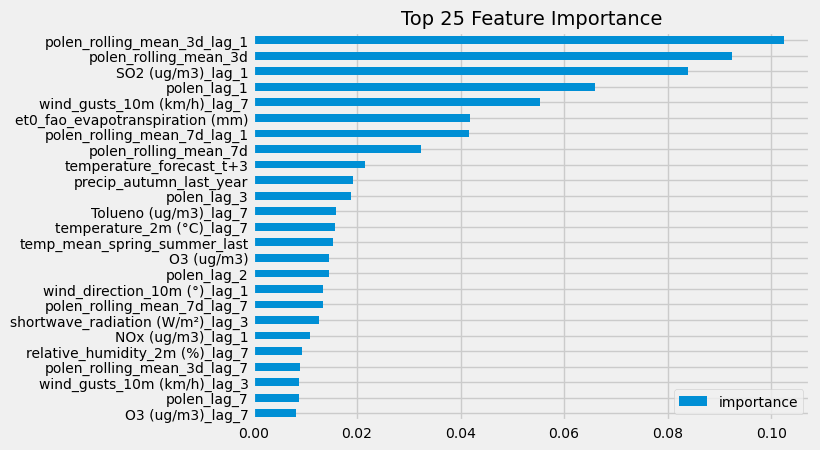

In [89]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance', ascending=False).head(25).sort_values('importance').plot(kind='barh', title='Top 25 Feature Importance')
plt.show()

### Predecir el próximo día

In [90]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [91]:
df = pd.read_csv(r"..\new_datasets\datos_gramineas.csv")
df = df.set_index("fecha")
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)

In [92]:
model = xgb.Booster()
model.load_model('modelo_t+1.json')

features_que_pide_el_modelo = model.feature_names

In [93]:
ultima_fila = df.tail(6)

input_data = ultima_fila[features_que_pide_el_modelo]

In [94]:
dmatrix_input = xgb.DMatrix(input_data)

prediccion_raw = model.predict(dmatrix_input)[0]

print(f"La predicción de polen para el próximo día es: {prediccion_raw:.2f}")

La predicción de polen para el próximo día es: 1.30
